In [1]:
from __future__ import annotations

import abc
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from tqdm.autonotebook import tqdm

from unet import Unet

# Diffusion Models On MNIST

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loading

In [3]:
mnist_train_ds = torchvision.datasets.MNIST(
    'mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda X: 2*X - 1),
    ]))

mnist_test_ds = torchvision.datasets.MNIST(
    'mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda X: 2*X - 1),
    ]))

## Diffusion Models
### Forward Process

In [4]:
class BetaScheduler(abc.ABC):
    def __init__(self, beta_start: float, beta_end: float, time_steps: int) -> None:
        self._time_steps = time_steps
        self._beta = self._schedule_beta(beta_start, beta_end, time_steps)
        self._alpha = 1. - self._beta
        self._alpha_bar = torch.cumprod(self._alpha, dim=0)
        self._1_minus_alpha_bar = 1. - self._alpha_bar
        self._sqrt_alpha_bar = torch.sqrt(self._alpha_bar)
        self._sqrt_1_minus_alpha_bar = torch.sqrt(self._1_minus_alpha_bar)

    @property
    def max_time_steps(self):
        return self._time_steps

    def beta(self, time_steps: torch.Tensor):
        return self._get_values_at(self._beta, time_steps)

    def alpha(self, time_steps: torch.Tensor):
        return self._get_values_at(self._alpha, time_steps)

    def one_minus_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._1_minus_alpha_bar, time_steps)

    def sqrt_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._sqrt_alpha_bar, time_steps)

    def sqrt_1_minus_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._sqrt_1_minus_alpha_bar, time_steps)

    @abc.abstractmethod
    def _schedule_beta(self, beta_start: float, beta_end: float, time_steps: int) -> torch.Tensor:
        pass

    def _get_values_at(self, values: torch.Tensor, time_steps: torch.Tensor) -> torch.Tensor:
        """
        Obtain values at given time steps.

        Parameters
        ==========
        values: torch.Tensor
            A tensor of shape (T,) containing values to be extracted at each time step.
        time_steps: torch.Tensor
            Time steps to be extracted, can be a tensor of shape (N, ) or a scalar tensor.
        """
        if len(time_steps.shape) == 0:
            return values[time_steps]

        v = torch.gather(values, 0, time_steps)
        return v[:, None]


class LinearBetaScheduler(BetaScheduler):
    def _schedule_beta(self, beta_start: float, beta_end: float, time_steps: int) -> torch.Tensor:
        return torch.linspace(beta_start, beta_end, time_steps)


class DiffusionForwardProcess:
    def __init__(self, beta_scheduler: BetaScheduler) -> None:
        self._beta_scheduler = beta_scheduler

    @property
    def max_time_steps(self):
        return self._beta_scheduler.max_time_steps

    @torch.no_grad()
    def forward(self, img: torch.Tensor, time_steps: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform diffusion forward process based on the nice property:
        q(x_t | x_0) = Normal(x_t; \sqrt{\bar{\alpha_t}}x_0, (1 - \bar{\alpha_t})I

        Parameters
        ==========
        img: torch.Tensor
            The original image (x_0), can be unbatched input (C, H, W) or batched input (N, C, H, W).
        time_steps: torch.Tensor
            The number of time steps (t) to perform forward process, can be a tensor of 1 value for unbatched |img|
            or a tensor (N,) for batched |img|.
        """
        is_batched_input = len(img.shape) == 4
        if is_batched_input:
            assert img.shape[0] == time_steps.shape[0]
        else:
            img = img[None, ...]
            time_steps = time_steps[None, ...]

        # Generate random noise.
        noise = torch.randn_like(img)

        # Generate noisy images.
        sqrt_alpha_bar = self._beta_scheduler.sqrt_alpha_bar(time_steps)[..., None, None]
        sqrt_1_minus_alpha_bar = self._beta_scheduler.sqrt_1_minus_alpha_bar(time_steps)[..., None, None]
        noisy_img = sqrt_alpha_bar * img + noise * sqrt_1_minus_alpha_bar

        return (noisy_img, noise) if is_batched_input else (noisy_img[0], noise[0])

Now, we will check if our forward process is working as intended.
We should see that as the time steps getting larger, our images become more and more noisy,
and eventually become random noises.

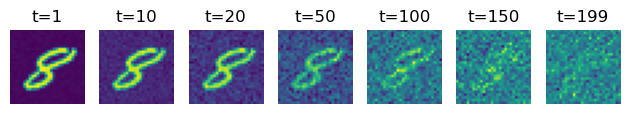

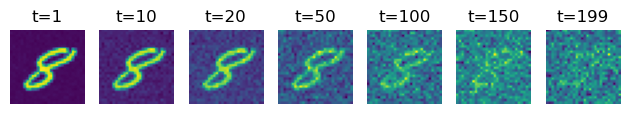

In [5]:
# It's important to get these parameters (beta_start, beta_end) right.
# When I set beta_end=0.2, the diffusion model will not work.
# It's interesting to know how the authors set these parameters right?
beta_scheduler = LinearBetaScheduler(1e-4, 0.02, 200)
forward_process = DiffusionForwardProcess(beta_scheduler)

time_steps = [1, 10, 20, 50, 100, 150, 199]
fig, axes = plt.subplots(ncols=len(time_steps))
for ax, t in zip(axes, time_steps):
    img, _ = mnist_train_ds[2555]
    noisy_img, _ = forward_process.forward(img, torch.tensor(t))
    ax.imshow(noisy_img[0])
    ax.axis('off')
    ax.set_title(f'{t=}')

fig.tight_layout()

fig, axes = plt.subplots(ncols=len(time_steps))
for ax, t in zip(axes, time_steps):
    img, _ = mnist_train_ds[2555]
    noisy_img, _ = forward_process.forward(img[None, ...], torch.tensor([t]))
    ax.imshow(noisy_img[0, 0])
    ax.axis('off')
    ax.set_title(f'{t=}')

fig.tight_layout()

### Backward Process
#### Diffusion Backward-Process Neural Network

### Training Process
#### Loss Function

In [6]:
def diffusion_loss(pred_noise, target_noise):
    # return F.mse_loss(pred_noise, target_noise)
    return F.smooth_l1_loss(pred_noise, target_noise)

#### Training and Evaluation Procedure

In [7]:
class MNISTDiffusionTrainingProcedure:
    def __init__(self, model: Unet, forward_process: DiffusionForwardProcess, device: str, lr=1e-3) -> None:
        self._model = model.to(device)
        self._forward_process = forward_process
        self._device = device

        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=lr)
        model.apply(lambda m: self._init_weights(m))
        
    def _init_weights(self, m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear]:
            strategy_fn(m.weight)

    def train(self, dataloader: DataLoader[torchvision.datasets.MNIST], epoch: int) -> float:
        self._model.train()

        nb_batches = len(dataloader)
        total_loss = 0.
        for X, _ in tqdm(dataloader, total=nb_batches, desc=f'Training epoch {epoch}'):
            loss = self._forward_step(X)
            total_loss += loss.item()

            # Perform gradient descent.
            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()

        return total_loss / nb_batches

    @torch.no_grad()
    def evaluate(self, dataloader: DataLoader[torchvision.datasets.MNIST]) -> float:
        self._model.eval()

        nb_batches = len(dataloader)
        total_loss = 0.
        for X, _ in tqdm(dataloader, total=nb_batches, desc='Evaluating'):
            total_loss += self._forward_step(X).item()

        return total_loss / nb_batches

    def _forward_step(self, X: torch.Tensor):
        # Generate noisy images.
        batch_size = X.shape[0]
        random_time_steps = torch.randint(0, self._forward_process.max_time_steps, size=(batch_size,))
        noisy_X, added_noise = self._forward_process.forward(X, random_time_steps)

        # Move the tensors to the desired device.
        noisy_X, added_noise = noisy_X.to(self._device), added_noise.to(self._device)
        random_time_steps = random_time_steps.to(self._device)

        # Feed the noisy images to model to get back predicted noise.
        pred_noise = self._model(noisy_X, random_time_steps)

        # Calculate the loss.
        loss = diffusion_loss(pred_noise, added_noise)
        return loss

### Model Training

In [8]:
mnist_train_dataloader = DataLoader(mnist_train_ds, batch_size=256, num_workers=4, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test_ds, batch_size=256, num_workers=4)

In [9]:
model = Unet(dim=28, channels=1, dim_mults=(1, 2, 4))
training_procedure = MNISTDiffusionTrainingProcedure(model, forward_process, device, lr=1e-3)

epochs = 1 if device == 'cpu' else 10
train_losses = []
test_losses = []
for epoch in range(epochs):
    train_loss = training_procedure.train(mnist_train_dataloader, epoch)
    test_loss = training_procedure.evaluate(mnist_test_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'{train_loss=:.4f} {test_loss=:.4f}')

Training epoch 0:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.1759 test_loss=0.0624


Training epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0443 test_loss=0.0360


Training epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0350 test_loss=0.0324


Training epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0319 test_loss=0.0311


Training epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0300 test_loss=0.0288


Training epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0291 test_loss=0.0281


Training epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0280 test_loss=0.0278


Training epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0270 test_loss=0.0263


Training epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0262 test_loss=0.0265


Training epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0256 test_loss=0.0273


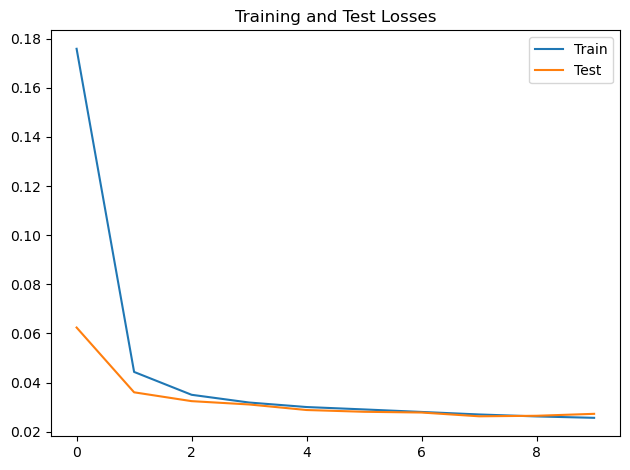

In [10]:
plt.figure()
plt.title('Training and Test Losses')
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), test_losses, label='Test')
plt.legend()
plt.tight_layout()

### Results

In [11]:
class DiffusionBackwardProcess:
    def __init__(self, model: Unet, beta_scheduler: BetaScheduler, device: str) -> None:
        self._model = model
        self._beta_scheduler = beta_scheduler
        self._device = device

    @torch.no_grad()
    def backward(self, noisy_img: torch.Tensor, time_step: int) -> torch.Tensor:
        """
        Perform diffusion backward process (the sampling algorithm in the paper).

        Parameters
        ==========
        noisy_img: torch.Tensor
            Noisy images, a tensor of shape (N, C, H, W) for batched input or (C, H, W) for unbatched input.
        time_step: int
            Time step of all images.
        """
        self._model.eval()
        is_batched_input = len(noisy_img.shape) == 4
        if is_batched_input:
            batch_size = noisy_img.shape[0]
            time_steps = torch.tensor([time_step]*batch_size)
        else:
            noisy_img = noisy_img[None, ...]
            time_steps = torch.tensor([time_step])

        pred_noise = self._model(noisy_img.to(self._device), time_steps.to(self._device)).cpu()
        means = self._means(noisy_img, pred_noise, time_steps)

        if time_step == 0:
            means = self._discretize(means)
            return means if is_batched_input else means[0]
        else:
            posterior_variances = self._posterior_variances(time_steps)
            random_noise = torch.randn_like(noisy_img)

            x = means + random_noise * torch.sqrt(posterior_variances)
            return x if is_batched_input else x[0]

    def _means(self, noisy_img: torch.Tensor, pred_noise: torch.Tensor, time_steps: torch.Tensor):
        """
        Calculate mean.
        """
        # TODO: how to handle time_steps = 0?
        sqrt_alpha_recip = 1. / torch.sqrt(self._beta_scheduler.alpha(time_steps))
        sqrt_1_minus_alpha_bar = self._beta_scheduler.sqrt_1_minus_alpha_bar(time_steps)
        beta = self._beta_scheduler.beta(time_steps)

        return sqrt_alpha_recip * (noisy_img - beta * pred_noise / sqrt_1_minus_alpha_bar)

    def _posterior_variances(self, time_steps: torch.Tensor) -> torch.Tensor:
        """
        Calculate posterior variances.

        Parameters
        ==========
        time_steps: torch.Tensor
            Time steps, can be a scalar tensor or a tensor of shape (N,).
        """
        # TODO: how to handle time_steps = 0?
        beta = self._beta_scheduler.beta(time_steps)
        one_minus_alpha_bar_t = self._beta_scheduler.one_minus_alpha_bar(time_steps)
        one_minus_alpha_bat_t_1 = self._beta_scheduler.one_minus_alpha_bar(time_steps - 1)
        return beta * one_minus_alpha_bat_t_1 / one_minus_alpha_bar_t
    
    def _discretize(self, images: torch.Tensor) -> torch.Tensor:
        # images = torch.clip(images, -1, 1)
        return images

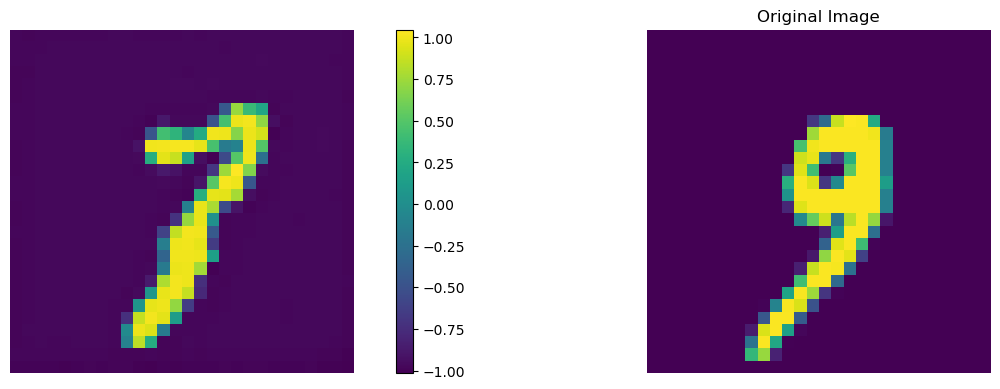

In [13]:
backward_process = DiffusionBackwardProcess(model, beta_scheduler, device)

original_img, _ = mnist_test_ds[1000]
noisy_img, _ = forward_process.forward(
    original_img, torch.tensor(forward_process.max_time_steps - 1))
recovered_imgs = []
recovered_img = noisy_img
for i in reversed(range(forward_process.max_time_steps)):
    recovered_img = backward_process.backward(recovered_img, i)

    if i % 200 == 0:
        recovered_imgs.append(recovered_img)

fig, axes = plt.subplots(ncols=len(recovered_imgs) + 1, figsize=(16, 4))
for ax, img in zip(axes, recovered_imgs):
    cs = ax.imshow(img[0])
    fig.colorbar(cs, ax=ax)
    ax.axis('off')

axes[-1].imshow(original_img[0])
axes[-1].set_title('Original Image')
axes[-1].axis('off')
fig.tight_layout()